# Demo of fitting the EnhancedSyntheticDistribution class

*Information and Decision Systems Group &mdash; FCFM &mdash; Universidad de Chile*

Tutorial authored by Camilo Ramírez

## 1. Obtain the "natural" data (generate *blobs* ✨)

In this example we will be working with magical blobs. Note that there is a parameter `conf` that controls confusion. Since there are 4 equiprobable classes, $H(Y) = 2\:\text{bits}$. Note that `conf == 0` implies that $I(X;Y) = 0$ and that `conf` tending to infinity implies that $I(X;Y) = 2\:\text{bits}$.

In [24]:
from sklearn.datasets import make_blobs, make_moons, make_classification
from bm.synthetic_distribution import SyntheticDistribution
from bm.experiments import dataset_utils

import matplotlib.pyplot as plt
import numpy.typing as npt
import numpy as np

In [53]:
conf: float = 1.5
centers = [[-2 * conf, 2 * conf], [conf, conf], [3 * conf, -3 * conf], [0, 0]]
N_SAMPLES = 10_000
dataset_name = "make_blobs"
config_name = "default"
hp_config =   {
    "n_samples": N_SAMPLES,
    "n_features": 2,
    "centers": 3,
    "cluster_std": 2.5,
}

dataset = dataset_utils.prepare_dataset(
    dataset_name="make_blobs",
    hp_config=hp_config,
    seed=1234,
)
dataset

(array([[ 2.57286783,  7.44034562],
        [ 8.12678039, -6.0341438 ],
        [-2.5836511 ,  6.17952895],
        ...,
        [-9.93357716,  5.08914107],
        [ 3.90917692, -2.52400337],
        [-5.24618298,  0.84857202]], shape=(10000, 2)),
 array([1, 2, 1, ..., 0, 2, 0], shape=(10000,)))

`blobs` is a tuple of numpy arrays such that `blobs[0]` is of shape `(n, d)` &ndash; where `n` is the number of samples ($n=10\:000$) and `d` is the number of features ($X$'s dimensionality; $d=2$) &ndash; and `blobs[1]` is of shape `(n,)` containing the class labels.

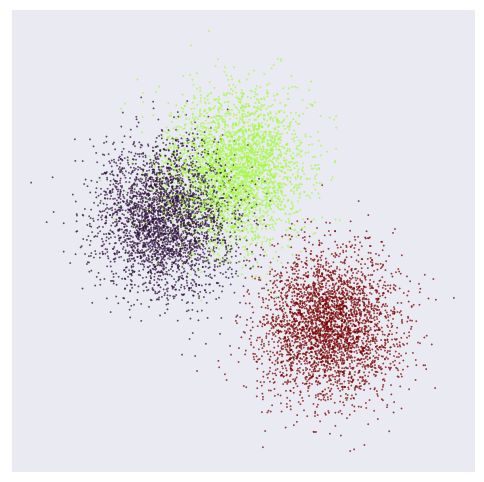

In [26]:
from bm.experiments import plotting_utils

fig = plotting_utils.plot_dataset_distribution(
    dataset.x,
    dataset.y,
    dataset_name,
    (config_name, hp_config),
    return_fig=True,
    add_info=False,
    no_borders=True,
)

## 1. Create synthetic distribution

## 2. Obtaining the empirical symbol probabilities

Now, we need to estimate $(p_y)_{y=1}^{m}$. In our case, $m=3$ since we have 3 classes; since the classes are equiprobable, we expect to obtain empirical probabilities close to $0.333$. 

**NOTE:** `make_blobs` generates exactly $n/m$ samples for each class (where $n$ is the number of samples), so the empirical probabilities will be exactly 0.333.

In [27]:
n_classes = len(np.unique(dataset.y))
n_features = dataset.x.shape[1]

probs: npt.NDArray[np.float64] = SyntheticDistribution.compute_empirical_probs(
    dataset.y,
    n_classes,
)
print(f"Number of classes: {n_classes}", f"Number of features: {n_features}")
print(f"Number of X samples: {len(dataset.x)}", f"Number of y samples: {len(dataset.y)}")

print(f"Probs: {probs}")
probs

Number of classes: 3 Number of features: 2
Number of X samples: 10000 Number of y samples: 10000
Probs: [0.3334 0.3333 0.3333]


array([0.3334, 0.3333, 0.3333])

`probs` is a numpy array of shape `(m,)` containing the empirical probabilities of each class.

## 3. Defining the cell limits &mdash; The space partition

Now, we need to define the array of cell limits for each dimension; i.e., $(\mathbf{a}_{\ell})_{\ell=1}^d$ (let us remember that in our case $d=2$), or in other words, $\mathbf{a}_1 = (a_{1,i})_{i=0}^{n_1}$ and $\mathbf{a}_2 = (a_{2,i})_{i=0}^{n_2}$. The values of $n_1$ and $n_2$ represent the number of intervals, or discretization levels, we will allow; these numbers ($n_1$ and $n_2$) are hyperparameters that we may choose on our will. Even more, $\mathbf{a}_1$ and $\mathbf{a}_2$ are hyperparameters, but for simplicity, we will use the `np.linspace` function to generate them.

In [28]:
n_features = dataset.x.shape[1]
grid_size: int = 100
bounds: npt.NDArray[np.object_] = SyntheticDistribution.make_bounds(
    dataset.x,
    n_features,
    grid_size,
)

bounds

array([array([-15.87185702, -15.56761587, -15.26337471, -14.95913356,
              -14.65489241, -14.35065125, -14.0464101 , -13.74216895,
              -13.43792779, -13.13368664, -12.82944549, -12.52520433,
              -12.22096318, -11.91672203, -11.61248087, -11.30823972,
              -11.00399857, -10.69975742, -10.39551626, -10.09127511,
               -9.78703396,  -9.4827928 ,  -9.17855165,  -8.8743105 ,
               -8.57006934,  -8.26582819,  -7.96158704,  -7.65734588,
               -7.35310473,  -7.04886358,  -6.74462242,  -6.44038127,
               -6.13614012,  -5.83189896,  -5.52765781,  -5.22341666,
               -4.9191755 ,  -4.61493435,  -4.3106932 ,  -4.00645204,
               -3.70221089,  -3.39796974,  -3.09372858,  -2.78948743,
               -2.48524628,  -2.18100512,  -1.87676397,  -1.57252282,
               -1.26828166,  -0.96404051,  -0.65979936,  -0.3555582 ,
               -0.05131705,   0.2529241 ,   0.55716526,   0.86140641,
                1.16

`bounds` is an object numpy array of shape `(d,)` such that `bounds[0]` is of shape `(n_1 + 1,)` and `bounds[1]` is of shape `(n_2 + 1,)`. The values in `bounds[0]` and `bounds[1]` are the limits of the intervals for each dimension, respectively. Note that the number of intervals is $n_1$ and $n_2$, but the number of limits is $n_1 + 1$ and $n_2 + 1$, respectively.

In [29]:
# n_1: int = 20
# n_2: int = 10
# bounds: npt.NDArray[np.object_] = np.empty(shape=(*x.shape[1:],), dtype=object)
# np.vectorize(lambda d: np.linspace(x[:, d].min(), x[:, d].max(), n_1 + 1))(np.arange(x.shape[1]))
# for d in x.shape[1:]:
#     for d_i in range(d):
#         bounds[d_i] = np.linspace(x[:, d_i].min(), x[:, d_i].max(), n_1 + 1)
# print(bounds.shape)
# bounds

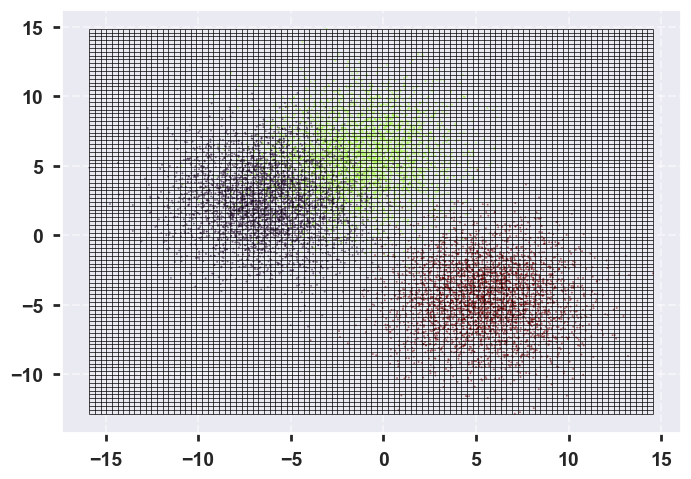

In [30]:
fig: plt.Figure
ax: plt.Axes
fig, ax = plt.subplots()
ax.scatter(dataset.x[:, 0], dataset.x[:, 1], c=dataset.y, cmap="turbo", s=1, alpha=0.5)
ax.vlines(
    x=bounds[0],
    ymin=bounds[1][0],
    ymax=bounds[1][-1],
    color="black",
    linestyle="-",
    linewidth=0.5,
)
ax.hlines(
    y=bounds[1],
    xmin=bounds[0][0],
    xmax=bounds[0][-1],
    color="black",
    linestyle="-",
    linewidth=0.5,
)
plt.show()

## 4. Obtaining the cell's (or interval's) conditioned probabilities

Now, we need to obtain the probabilities of each cell (or interval, if we are fitting marginals) conditioned to each class. We will do this exercise in two scenarios: Fitting marginals and fitting the joint distribution.

### 4.1 Fitting marginals

When fitting marginals, we consider a number of $G=d$ *group of coordinates*, where each *group of coordinates* is actually a single coordinate. In our case, we have $G=2$ groups of coordinates (one for each dimension) each one containing $d_1=d_2=1$ coordinate.

There exists a function $\gamma$ that maps pairs $(\ell,k)$, where $\ell$ is the group index and $k$ is the *inner coordinate index*, to *absolute coordinate indexes*. In this case, this function is simple: all its possible values are $\gamma(1,1) = 1$ and $\gamma(2,1) = 2$.

Now, we define, for each coordinate group (i.e., for $\ell\in\{1,2\}$), a cell indexation. In this case, since all groups of coordinates contain only one coordinate, the cells are 1D intervals. We define each cell indexation as follows:
- $\mathcal{I}_1 = \times_{k=1}^{d_1}[n_{\gamma(1,k)}] = [n_{\gamma(1,1)}] = [n_1] = \{1,2,\ldots,n_1\}$.
- $\mathcal{I}_2 = \times_{k=1}^{d_2}[n_{\gamma(2,k)}] = [n_{\gamma(2,1)}] = [n_2] = \{1,2,\ldots,n_2\}$.

Then, the set of all possible combinations of group indexes ($\ell$) and cell indexes for them ($\mathbf{i}$) are defined by
- $\mathcal{I} = \bigcup_{k=1}^G(\{k\}\times\mathcal{I}_k) = (\{1\}\times[n_1])\cup(\{2\}\times[n_2]) = \{(1,1),(1,2),\ldots(1,n_1),(2,1),(2,2),\ldots,(2,n_2)\}$.

Now, we need to estimate $((p_{\mathbf{i}|\ell,y})_{(\ell,\mathbf{i})\in\mathcal{I}})_{y=1}^m$. In other words, we need to estimate all conditional probabilities for each interval of the first and second coordinate, respectively: $((p_{1|1,y})_{y=1}^4,(p_{2|1,y})_{y=1}^4,\ldots,(p_{n_1|1,y})_{y=1}^4)$ and $((p_{1|2,y})_{y=1}^4,(p_{2|2,y})_{y=1}^4,\ldots,(p_{n_2|2,y})_{y=1}^4)$.

In [31]:
marginal_cond_probs = SyntheticDistribution.make_marginal_cond_probs(
    dataset.x,
    dataset.y,
    bounds,
    grid_size,
)
marginal_cond_probs

array([array([[0.00029994, 0.        , 0.        , 0.00029994, 0.        ,
               0.00059988, 0.        , 0.00059988, 0.        , 0.00059988,
               0.00269946, 0.00059988, 0.00269946, 0.0044991 , 0.00479904,
               0.00569886, 0.00779844, 0.0134973 , 0.0104979 , 0.01679664,
               0.0194961 , 0.02039592, 0.02009598, 0.02939412, 0.03269346,
               0.03329334, 0.03719256, 0.04529094, 0.04439112, 0.04889022,
               0.05308938, 0.04739052, 0.04559088, 0.04679064, 0.05278944,
               0.04409118, 0.0374925 , 0.03989202, 0.03989202, 0.02819436,
               0.02369526, 0.02759448, 0.0194961 , 0.01889622, 0.01829634,
               0.01229754, 0.00809838, 0.0074985 , 0.0089982 , 0.00539892,
               0.00269946, 0.00269946, 0.00239952, 0.00179964, 0.00059988,
               0.00089982, 0.00029994, 0.        , 0.        , 0.        ,
               0.        , 0.        , 0.        , 0.        , 0.        ,
               0.        

`marginal_cond_probs` is an object numpy array of shape `(G,)` such that `marginal_cond_probs[0]` is of shape `(m, n_1)` and `marginal_cond_probs[1]` is of shape `(m, n_2)`. The values in `marginal_cond_probs[0]` are the conditional probabilities of each interval of the first coordinate conditioned to each class, and the values in `marginal_cond_probs[1]` are the conditional probabilities of each interval of the second coordinate conditioned to each class.

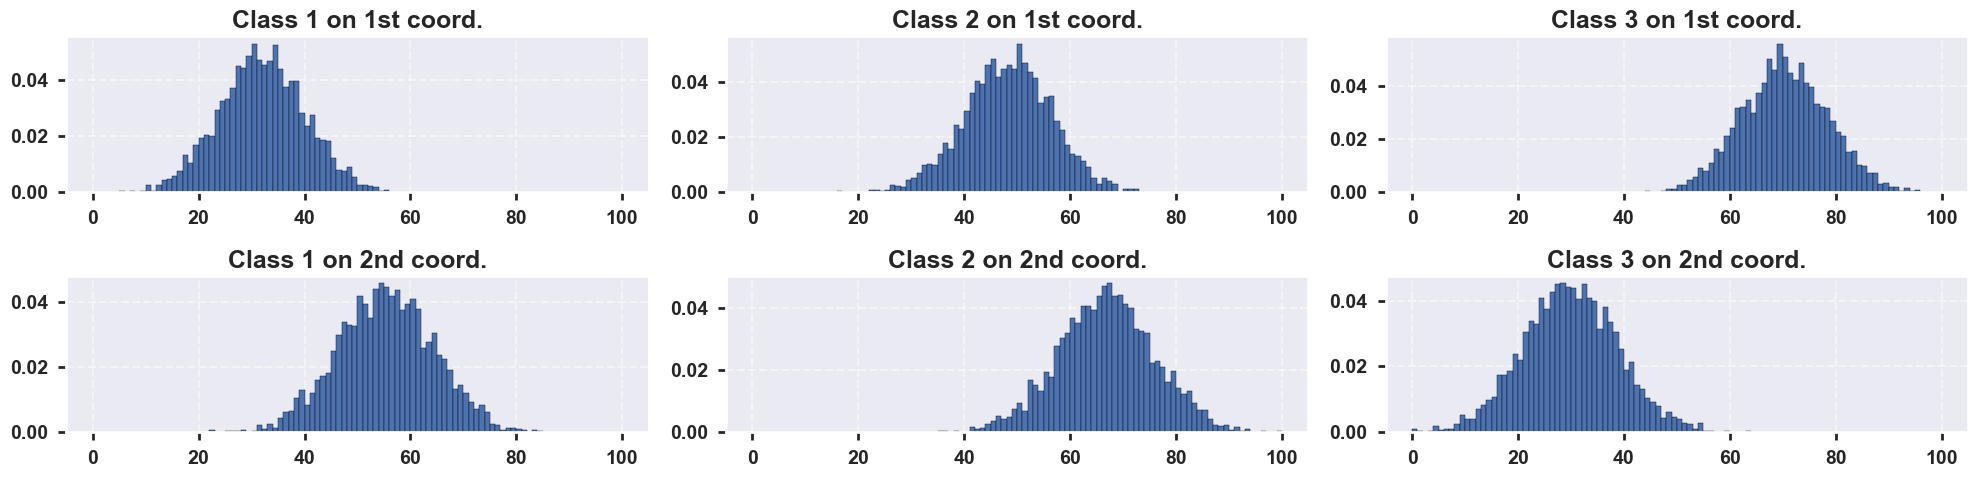

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=n_classes, figsize=(20, 5))
for class_idx in range(n_classes):
    ax[0, class_idx].bar(
        x=np.arange(grid_size),
        height=marginal_cond_probs[0][class_idx],
        width=1,
        align="edge",
        edgecolor="black",
    )
    ax[0, class_idx].set_title(label=f"Class {class_idx + 1} on 1st coord.")
    ax[1, class_idx].bar(
        x=np.arange(grid_size),
        height=marginal_cond_probs[1][class_idx],
        width=1,
        align="edge",
        edgecolor="black",
    )
    ax[1, class_idx].set_title(label=f"Class {class_idx + 1} on 2nd coord.")
fig.tight_layout()

### 4.2 Fitting the joint distribution

When fitting the joint distribution, we consider $G=1$ *group coordinate* that contains all coordinates; then, $d_1=d=2$.

There exists a function $\gamma$ that maps pairs $(\ell,k)$, where $\ell$ is the group index and $k$ is the *inner coordinate index*, to *absolute coordinate indexes*. In this case, this function is also simple: all its possible values are $\gamma(1,1) = 1$ and $\gamma(1,2) = 2$.

Now, we define, for each coordinate group (i.e., our only coordinate group $\ell\in\{1\}$), a cell indexation. In this case, since the only group coordinate contains two coordinates, the cells are 2D rectangles. We define the cell indexation as follows:
- $\mathcal{I}_1 = \times_{k=1}^{d_1}[n_{\gamma(1,k)}] = [n_{\gamma(1,1)}]\times[n_{\gamma(1,2)}] = [n_1]\times[n_2] = \{1,2,\ldots,n_1\}\times\{1,2,\ldots,n_2\}.$

Then, the set of all possible combinations of group indexes ($\ell$) and cell indexes for them ($\mathbf{i}$) are defined by
- $\mathcal{I} = \bigcup_{k=1}^G(\{k\}\times\mathcal{I}_k) = \{1\}\times([n_1]\times[n_2]) = \{(1,(1,1)),(1,(1,2)),\ldots,(1,(1,n_2)),(1,(2,1)),(1,(2,2)),\ldots,(1,(2,n_2)),(1,(n_1,1)),(1,(n_1,2)),\ldots,(1,(n_1,n_2))\}$.

Now, we need to estimate $((p_{\mathbf{i}|\ell,y})_{(\ell,\mathbf{i})\in\mathcal{I}})_{y=1}^m$. In other words, we need to estimate all conditional probabilities for each rectangle of first and second coordinates: $(p_{(i,j)|1,y})_{y=1}^4$ for all $(i,j)\in[n_1]\times[n_2]$.

In [33]:
joint_cond_probs = SyntheticDistribution.make_joint_cond_probs(
    dataset.x,
    dataset.y,
    bounds,
    grid_size,
)
joint_cond_probs

array([array([[[0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               ...,
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.]],

              [[0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               ...,
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.]],

              [[0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               ...,
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.],
               [0., 0., 0., ..., 0., 0., 0.]]], shape=(3, 100, 100))],
      dtype=object)

`joint_cond_probs` is an object numpy array of shape `(G,)` such that `cond_probs[0]` is of shape `(m, n_1, n_2)`. The values in `joint_cond_probs[0]` are the conditional probabilities of each rectangle of first and second coordinates conditioned to each class.


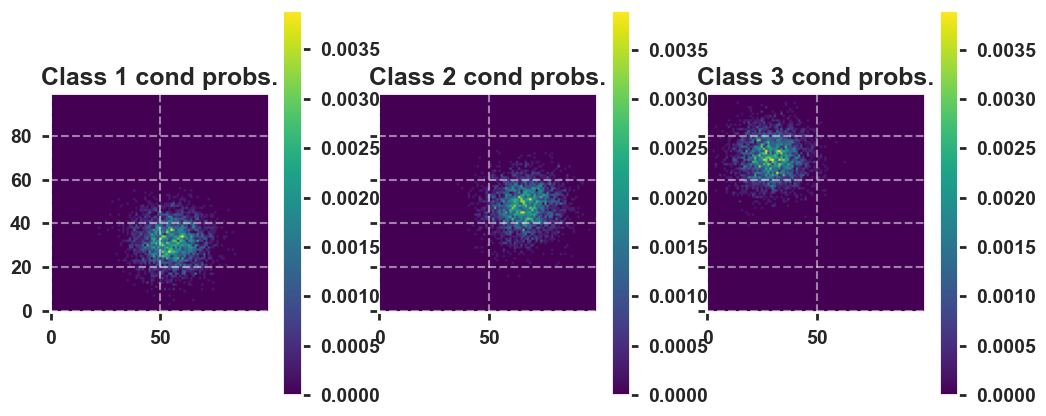

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=n_classes, figsize=(4 * n_classes, 5), sharex=True, sharey=True)
for class_idx in range(n_classes):
    img = ax[class_idx].imshow(
        joint_cond_probs[0][class_idx],
        cmap="viridis",
        origin="lower",
    )
    ax[class_idx].set_title(label=f"Class {class_idx + 1} cond probs.")
    fig.colorbar(mappable=img, ax=ax[class_idx])

## 5. Generate synthetic data and compute the mutual information!

Finally, we can fit our convoluted distribution for each case, generate synthetic data (and visualize it) and compute the analytical mutual information for each case.

### 5.1 Model from marginals

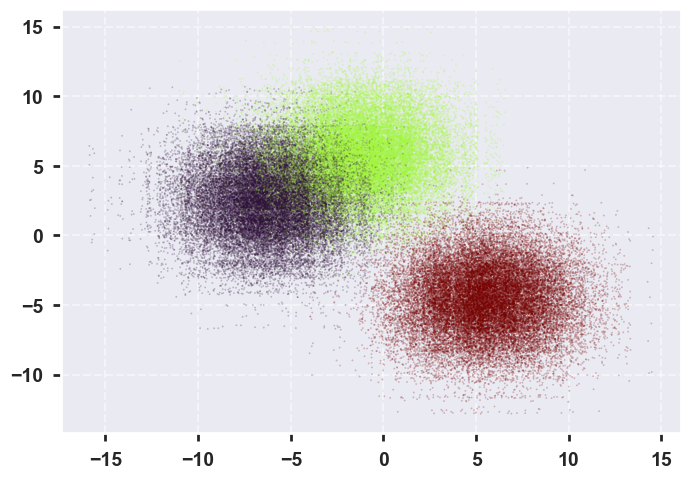

In [35]:
model_from_marginals: SyntheticDistribution = SyntheticDistribution(
    symbol_probabilities=probs,
    interval_bounds=bounds,
    cell_probabilities=marginal_cond_probs,
)
synthetic_marginal_data = model_from_marginals.sample_data(
    num_samples=100_000,
    seed=1234,
)
plt.scatter(
    synthetic_marginal_data[0][:, 0],
    synthetic_marginal_data[0][:, 1],
    c=synthetic_marginal_data[1],
    cmap="turbo",
    s=1,
    alpha=0.2,
)


In [36]:
symbol_entropy = model_from_marginals.get_symbol_entropy()
print(f"Symbol entropy: {symbol_entropy:.3f} bits")
print(
    f"I(0;Y): {model_from_marginals.get_mutual_information(coordinates=set()):.3f} bits"
)
print(
    f"I(X_1;Y): {model_from_marginals.get_mutual_information(coordinates={1}):.3f} bits"
)
print(
    f"I(X_2;Y): {model_from_marginals.get_mutual_information(coordinates={2}):.3f} bits"
)
joint_mi = model_from_marginals.get_mutual_information(coordinates={1, 2})
print(f"I(X;Y): {joint_mi:.3f} bits")
# induced_loss = model_from_marginals.compute_induced_loss(joint_mi, symbol_entropy)
# print(f"Loss: {induced_loss:.3f} bits")

Symbol entropy: 1.585 bits
I(0;Y): 0.000 bits
I(X_1;Y): 1.040 bits
I(X_2;Y): 0.900 bits
I(X;Y): 1.301 bits


### 5.2 Model from the joint distribution

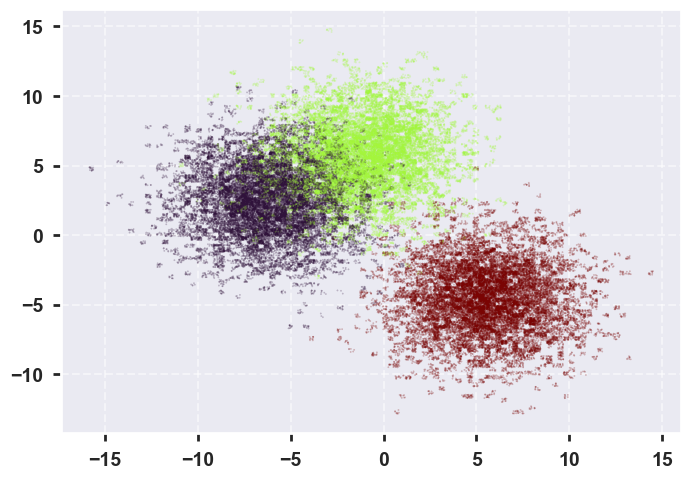

In [37]:
model_from_joint: SyntheticDistribution = SyntheticDistribution(
    symbol_probabilities=probs,
    interval_bounds=bounds,
    cell_probabilities=joint_cond_probs,
)
synthetic_joint_data = model_from_joint.sample_data(num_samples=100_000, seed=1234)
plt.scatter(
    synthetic_joint_data[0][:, 0],
    synthetic_joint_data[0][:, 1],
    c=synthetic_joint_data[1],
    cmap="turbo",
    s=1,
    alpha=0.2,
)

In [51]:
symbol_entropy = model_from_joint.get_symbol_entropy()
print(f"Symbol entropy: {symbol_entropy:.4f} bits")
print(
    f"I(0;Y): {model_from_joint.get_mutual_information(coordinates=set()):.4f} bits"
)
print(
    f"I(X_1;Y): {model_from_joint.get_mutual_information(coordinates={1}):.4f} bits"
)
print(
    f"I(X_2;Y): {model_from_joint.get_mutual_information(coordinates={2}):.4f} bits"
)
joint_mi = model_from_joint.get_mutual_information(coordinates={1, 2})
print(f"I(X;Y): {joint_mi:.4f} bits")
analytical_loss = model_from_joint.compute_analytical_loss(joint_mi, symbol_entropy)
print(f"Loss: {analytical_loss:.4f} bits")

Symbol entropy: 1.5850 bits
I(0;Y): 0.0000 bits
I(X_1;Y): 1.0396 bits
I(X_2;Y): 0.8999 bits
I(X;Y): 1.3859 bits
Loss: 0.1991 bits


Number of classes: 3
Input dimension: 2
Epoch [1/10], Train Loss: 0.5006, Test Loss: 0.2409, Train Acc: 84.76%, Test Acc: 90.85%
Epoch [2/10], Train Loss: 0.2171, Test Loss: 0.2234, Train Acc: 91.31%, Test Acc: 90.85%
Epoch [3/10], Train Loss: 0.2090, Test Loss: 0.2203, Train Acc: 91.33%, Test Acc: 91.00%
Epoch [4/10], Train Loss: 0.2063, Test Loss: 0.2234, Train Acc: 91.41%, Test Acc: 91.00%
Epoch [5/10], Train Loss: 0.2058, Test Loss: 0.2190, Train Acc: 91.47%, Test Acc: 91.25%
Epoch [6/10], Train Loss: 0.2046, Test Loss: 0.2186, Train Acc: 91.50%, Test Acc: 91.05%
Epoch [7/10], Train Loss: 0.2046, Test Loss: 0.2188, Train Acc: 91.41%, Test Acc: 91.25%
Epoch [8/10], Train Loss: 0.2044, Test Loss: 0.2194, Train Acc: 91.38%, Test Acc: 90.75%
Epoch [9/10], Train Loss: 0.2049, Test Loss: 0.2232, Train Acc: 91.35%, Test Acc: 90.90%
Epoch [10/10], Train Loss: 0.2036, Test Loss: 0.2193, Train Acc: 91.33%, Test Acc: 91.25%


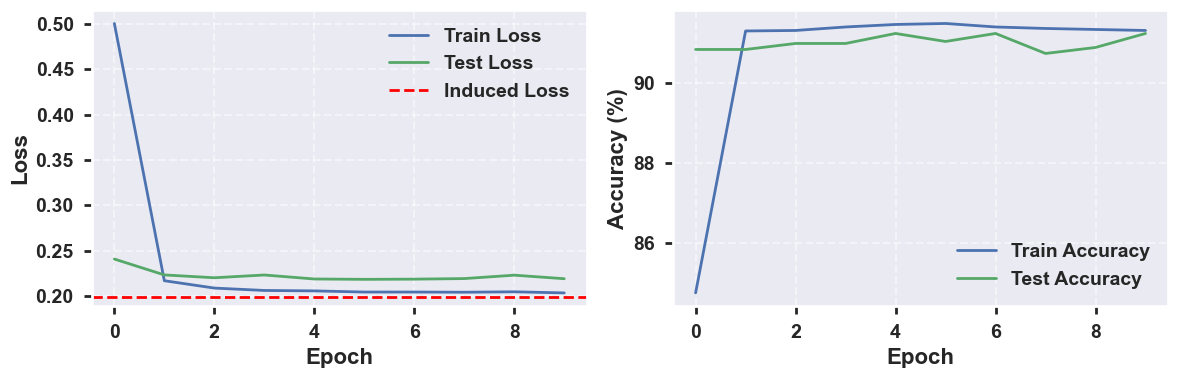

In [56]:
# Train a simple MLP on the synthetic data
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


# Convert data to PyTorch tensors
X = torch.FloatTensor(dataset.x)
y = torch.LongTensor(dataset.y)

# Create dataset and dataloader
tensor_dataset = TensorDataset(X, y)
train_size = int(0.8 * len(tensor_dataset))
test_size = len(tensor_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    tensor_dataset, [train_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define simple MLP
class SimpleMLP(nn.Module):
    """A simple Multi-Layer Perceptron (MLP) for classification."""

    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_layer_sizes: tuple[int, ...],
    ) -> None:
        """Initialize the MLP."""
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_layer_sizes:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the MLP."""
        return self.network(x)


# Initialize model, loss function and optimizer
num_classes: int = y.unique().size(0)
print(f"Number of classes: {num_classes}")
print(f"Input dimension: {dataset.x.shape[1]}")
model: SimpleMLP = SimpleMLP(
    input_dim=dataset.x.shape[1],
    output_dim=num_classes,
    hidden_layer_sizes=(32, 16),
)
criterion: nn.Module = nn.CrossEntropyLoss()
optimizer: torch.optim.Optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()

    # Testing
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += y_batch.size(0)
            test_correct += (predicted == y_batch).sum().item()

    # Record metrics
    train_losses.append(train_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    train_accs.append(100 * train_correct / train_total)
    test_accs.append(100 * test_correct / test_total)

    if (epoch + 1) % (num_epochs // 10) == 0 or epoch == num_epochs - 1:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Train Loss: {train_losses[-1]:.4f}, "
            f"Test Loss: {test_losses[-1]:.4f}, "
            f"Train Acc: {train_accs[-1]:.2f}%, "
            f"Test Acc: {test_accs[-1]:.2f}%"
        )

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(np.array(train_losses), label="Train Loss")
plt.plot(np.array(test_losses), label="Test Loss")
plt.axhline(y=analytical_loss, color="r", linestyle="--", label="Induced Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.show()
